#### authors: Rafael Dousse, Eva Ray, Massimo Stefani

In [2]:
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Binarizer, LabelEncoder, MaxAbsScaler, MinMaxScaler, OneHotEncoder, \
    OrdinalEncoder, RobustScaler, StandardScaler

# Exercise 2 - Debugging - Drugs

The dataset contains a set of patients, all of whom suffered from the same illness.
During their course of treatment, each patient responded to one of 5 medications: Drug A, Drug B, Drug c, Drug x or y.

This complex dataset proposes a set of challenges that you'll try to overcome. A basic ML pipeline is already in place. You have to optimize the performance of the model by applying good practices, debugging pre-processing errors, etc.

**Rules**:
- Do not use other modules than those already imported *(or do it only if your own code is not working. In this case, keep your own code in the notebook, commented, so that we know what you tried)*.
- Explain **all** of your choices. For every task, choose the most appropriate option for this problem and describe your choice.
- You can modify any parts of the code or replace the model by one already used in previous PWs.

**Work to do**:
- [ ] Apply a type of normalization.
- [ ] Encode categorical data.
- [ ] Use all columns in the dataset (or choose the most meaningful features).
- [ ] Choose a more appropriate metric.
- [ ] Optimize hyper-parameters.
- [ ] Test the model performance correctly using a separated test set.
- Apply **two** of those techniques:
  - [ ] Keep relative class frequencies in the train/test sets (check train_test_split docs)
  - [ ] Show which feature(s) are the most correlated to the target.
  - [ ] Use cross-validation.

In [67]:
df = pd.read_csv("drug.csv")
df.head()

,age,sex,bp,cholesterol,Na_to_K,drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   age      200 non-null    int64  
 1   Na_to_K  200 non-null    float64
 2   drug     200 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 4.8+ KB


In [85]:
df.describe()

,age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [73]:
categorical_columns = ["sex", "bp", "cholesterol", "drug"]

# TODO: you will replace this by a more adapted preprocessing step
df = df.drop(columns=["sex", "bp", "cholesterol"])

In [74]:
# Let's keept this to separate features and target variable
X = df.drop(columns="drug")
y = df["drug"]

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# TODO: preprocessing / encoding / normalization are likely missing here...


In [76]:
knn = KNeighborsClassifier(100)  # you may change the classifier if you want, or tune its hyperparameters
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=100)

In [77]:
def predict(estimator, X, y):
    # predict
    y_pred = estimator.predict(X)
    
    # show confusion matrix
    cm = confusion_matrix(y, y_pred)
    disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=estimator.classes_)
    disp.plot()
    
    # check metric (this one is probably not the best choice...)
    metric = metrics.accuracy_score(y, y_pred)
    print(f"Accuracy: {metric}")

Accuracy: 0.49375


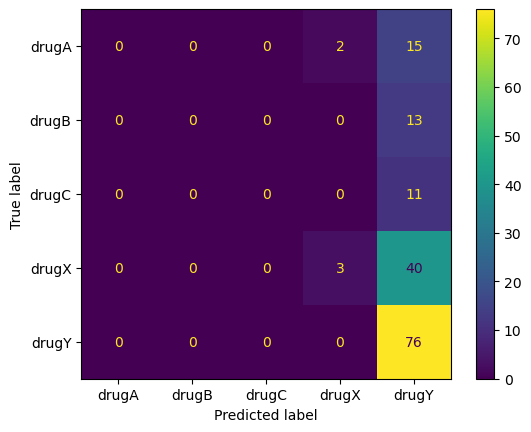

In [78]:
predict(knn, X_train, y_train)

In [ ]:
# TODO: Adapt the code above to your needs according to the problems you identify. A good way to 
# do it would be to tell us a story, starting from a baseline system and improving it step by step.
# E.g.: system A = baseline, system B = system A + preprocessing, system C = system B + hyperparameter tuning, etc.

## Code with pre-processing 

We can identify two types of features in the dataset: numerical and categorical features.
The numerical features are `age` and `Na to K` ratio, while the categorical ones are `sex`, `BP`, `cholesterol`, and `drug` (the target variable).

***Numerical features***: The numerical values need to be normalized since they vary on different scales like the patient's age ranges from 15 to 74 years old (see  df.describe()), while the `Na to K` ratio ranges from 6.3 to 38.5 (see df.describe()). Without normalization, features with larger ranges could influence the model more than those with smaller ranges.
We use `StandardScaler` to standardize the numerical features. This scaler transforms the data to have a mean of 0 and a standard deviation of 1, which is suitable for algorithms like KNN that rely on distance calculations.

***Categorical features***: The categorical data must be encoded because the model cannot directly process string values (like "M" or "HIGH").

- The column "sex" is part of the input features (X). It contains nominal categories ("M" and "F") with no natural order. So, we use a `OneHotEncoder`, which creates independent binary columns for each category. For example:
F → [1, 0], M → [0, 1]
or, with `drop='first'`: F → 0, M → 1 

- The columns `BP` and `Cholesterol` are ordinal because their categories have a natural order since we have low < normal < high for `BP` and low < high for `Cholesterol`. That's why we use `OrdinalEncoder` to preserve this ordering.

- Finally, the column "drug" is the target variable. Since classification algorithms like `KNeighborsClassifier` needs numerical labels, we use a `LabelEncoder` to transform each drug name into an integer label, like:
drugA → 0, drugB → 1, drugC → 2... <br> Also, the numbers do not represent any order, they are just identifiers for each class.

In [106]:

def preprocessing(X, y):
    ''' Preprocessing function to encode categorical features and normalize numerical features. Works only with the drug dataset.
    Args:
        X: input features
        y: target variable
    '''
    # extracting unique categories for ordinal encoding
    categories_bp = X["bp"].unique().tolist()
    categories_chol = X["cholesterol"].unique().tolist()

    # encoding of y 
    le = LabelEncoder()
    y = le.fit_transform(y)

    # ordinale encoding of bp and cholesterol
    ord_enc = OrdinalEncoder(categories=[categories_bp, categories_chol])
    X[["bp","cholesterol"]] = ord_enc.fit_transform(X[["bp", "cholesterol"]])

    # one hot encoding of sex
    onehot_enc = OneHotEncoder(sparse_output=False, drop='first')
    onehot_encoded = onehot_enc.fit_transform(X[["sex"]])
    onehot_df = pd.DataFrame(onehot_encoded, columns=onehot_enc.get_feature_names_out(["sex"]))

    X = pd.concat([onehot_df, X.drop(columns=["sex"]).reset_index(drop=True) ], axis=1)

    # normalization of numerical features
    std_scaler = StandardScaler()

    scaler = StandardScaler()
    X[["age", "Na_to_K"]] = scaler.fit_transform(X[["age", "Na_to_K"]])
    return X, y, le


In [134]:
df = pd.read_csv("drug.csv")
X = df.drop(columns="drug")
y = df["drug"]

In [135]:
X_preproc, y_preproc, _ = preprocessing(X, y)

In [90]:
X_preproc

,sex_M,age,bp,cholesterol,Na_to_K
0,0.0,-1.291591,0.0,0.0,1.286522
1,1.0,0.162699,1.0,0.0,-0.415145
2,1.0,0.162699,1.0,0.0,-0.828558
3,0.0,-0.988614,2.0,0.0,-1.149963
4,0.0,1.011034,1.0,0.0,0.271794
...,...,...,...,...,...
195,0.0,0.708057,1.0,0.0,-0.626917
196,1.0,-1.715759,1.0,0.0,-0.565995
197,1.0,0.465676,2.0,0.0,-0.859089
198,1.0,-1.291591,2.0,1.0,-0.286500


In [91]:
y_preproc

array([4, 2, 2, 3, 4, 3, 4, 2, 4, 4, 2, 4, 4, 4, 3, 4, 3, 0, 2, 4, 4, 4,
       4, 4, 4, 4, 4, 3, 4, 4, 3, 1, 3, 4, 3, 3, 0, 3, 3, 3, 4, 1, 4, 3,
       3, 3, 0, 2, 4, 4, 4, 3, 4, 4, 1, 2, 1, 4, 3, 4, 4, 0, 4, 3, 1, 4,
       0, 3, 4, 4, 1, 4, 3, 4, 4, 4, 0, 4, 0, 3, 1, 3, 2, 0, 2, 1, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 0, 0, 2, 3, 4, 3, 3, 4, 1, 4,
       0, 3, 3, 3, 3, 4, 3, 3, 0, 4, 4, 4, 4, 4, 1, 4, 4, 3, 4, 3, 4, 4,
       3, 4, 4, 3, 1, 0, 1, 3, 0, 4, 1, 4, 0, 3, 3, 0, 3, 2, 0, 1, 3, 3,
       4, 2, 0, 4, 2, 3, 3, 1, 3, 4, 4, 4, 4, 3, 4, 0, 3, 3, 4, 4, 0, 4,
       0, 4, 4, 4, 4, 3, 3, 4, 4, 4, 1, 0, 4, 4, 4, 0, 4, 2, 4, 2, 2, 3,
       3, 3])

In [136]:
X_train_preproc, X_test_preproc, y_train_preproc, y_test_preproc = train_test_split(X_preproc, y_preproc, test_size=0.2, random_state=42)

In [ ]:
knn_preproc = KNeighborsClassifier(100)  
knn_preproc.fit(X_train_preproc, y_train_preproc)

KNeighborsClassifier(n_neighbors=100)

Accuracy: 0.6875


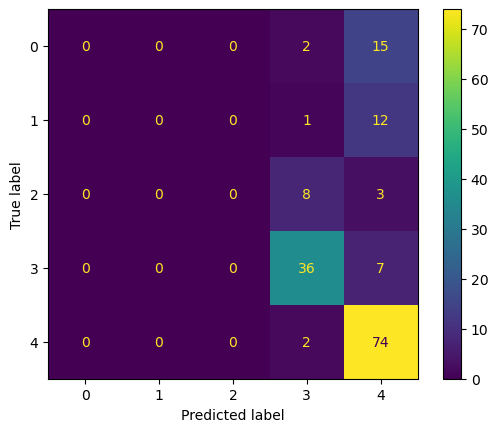

In [138]:
predict(knn_preproc, X_train_preproc, y_train_preproc)

We can already see a significant improvement in the model's performance after applying the correct preprocessing steps. The accuracy went from 49% to 68%. Now the issue lies in the fact that we have 100 neighbors in the KNN model, which is too high. We need to reduce this number to a more reasonable value by finding a more reasonable value.

## With fine tuning

In [126]:
df = pd.read_csv("drug.csv")
X = df.drop(columns="drug")
y = df["drug"]

X_fine, y_fine, le = preprocessing(X, y)
labels = le.classes_
label_indices = np.arange(len(labels))

`stratify` argument allows to keep [class distribution](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) in train and test sets.

In [131]:
X_train_fine, X_test_fine, y_train_fine, y_test_fine = train_test_split(X_fine, y_fine, test_size=0.2, random_state=42, stratify=y)

In [127]:
def fine_tuning_knn(X_train_prep, y_train):
    k_grid = [ 3, 5, 7, 9, 11, 15, 20, 30]
    cv_scores = {}
    for k in k_grid:
        clf = KNeighborsClassifier(n_neighbors=k)
        scores = model_selection.cross_val_score(
            clf, X_train_prep, y_train, cv=5, scoring='f1_macro'
        )
        cv_scores[k] = scores.mean()

    best_k = max(cv_scores, key=cv_scores.get)
    print("CV macro-F1 per k:", cv_scores)
    print("Best k:", best_k)
    return best_k


def evaluate(estimator, X_test, y_test, labels_idx, labels):
    y_pred = estimator.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    f1  = metrics.f1_score(y_test, y_pred, average='macro')
    print(f"Accuracy: {acc:.4f} | Macro-F1: {f1:.4f}")
    cm = confusion_matrix(y_test, y_pred, labels=labels_idx)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(xticks_rotation=45)




In [113]:
best_k = fine_tuning_knn(X_train_fine, y_train_fine)
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_fine, y_train_fine)

CV macro-F1 per k: {3: 0.7472557890452627, 5: 0.7922332672044048, 7: 0.7676466498314097, 9: 0.7627203887693252, 11: 0.7952125704564362, 15: 0.7894693894205632, 20: 0.6967896568041759, 30: 0.6875792357828538}
Best k: 11


KNeighborsClassifier(n_neighbors=11)

Accuracy: 0.9250 | Macro-F1: 0.8903


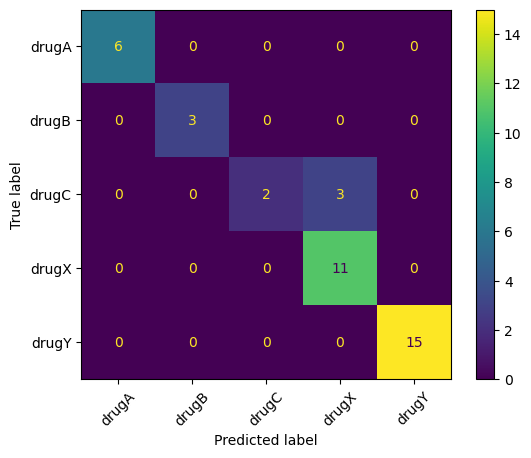

In [130]:
evaluate(knn, X_test_fine, y_test_fine, label_indices, labels)

Now we have a better accuracy of 92%, with a more reasonable number of neighbors -> k = 11. <br>
But the accuracy shows that the model correctly classifies most samples either right or wrong, but it does not distinguish when it's doing well on all classes. In our case, the F1-score is a more reliable metric to know which drugs are well classified as it shows how well the model identifies each drug type, including less common ones which can be essential when predicting treatments. Here we have an F1-score of 89% which indicates that the model performs well across all drug categories.